<a href="https://colab.research.google.com/github/fatsoengineer/Computer_Vision_Course/blob/master/S5/1st_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step - 1

**Target:**

> Create base model

**Results**


> 
*   Total params: 10,368
*   Best Test Accuracy: 
```
EPOCH: 14
Loss=0.044927358627319336 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:10<00:00, 43.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0316, Accuracy: 9903/10000 (99.03%)
```


**Analysis**

> * Created a model with three blocks and tried to keep the number of parameters around 10000, so, it wont be too hard to again reduce number of layers or parameters.
* Because I chose three blocks, I used two max pooling, and keeping the size of image in mind, added paading in the first block
* Ran multiple times to confirm that the results are not fluke or not fluctuating from each training at large 





# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
from torchsummary import summary

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


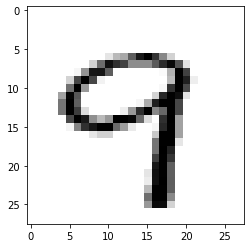

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

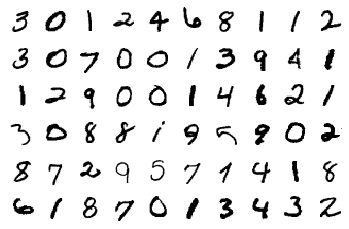

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            
            nn.ReLU(),

            
            # nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            
            # nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2,2))

        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            
            nn.ReLU(),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2,2))

        )


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU(),

            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU(),

        )


        self.reducer = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)

        x = self.reducer(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             576
              ReLU-4            [-1, 8, 28, 28]               0
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 12, 14, 14]             864
              ReLU-7           [-1, 12, 14, 14]               0
            Conv2d-8           [-1, 12, 14, 14]           1,296
              ReLU-9           [-1, 12, 14, 14]               0
        MaxPool2d-10             [-1, 12, 7, 7]               0
           Conv2d-11             [-1, 20, 5, 5]           2,160
             ReLU-12             [-1, 20, 5, 5]               0
           Conv2d-13             [-1, 20, 3, 3]           3,600
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.12138544768095016 Batch_id=468 Accuracy=60.68: 100%|██████████| 469/469 [00:12<00:00, 43.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1389, Accuracy: 9564/10000 (95.64%)

EPOCH: 1


Loss=0.050027865916490555 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:11<00:00, 41.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0784, Accuracy: 9763/10000 (97.63%)

EPOCH: 2


Loss=0.012384344823658466 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:12<00:00, 38.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9816/10000 (98.16%)

EPOCH: 3


Loss=0.03086680918931961 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9833/10000 (98.33%)

EPOCH: 4


Loss=0.008070752024650574 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:12<00:00, 37.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9868/10000 (98.68%)

EPOCH: 5


Loss=0.060182999819517136 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:11<00:00, 39.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9865/10000 (98.65%)

EPOCH: 6


Loss=0.011498600244522095 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:11<00:00, 39.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9864/10000 (98.64%)

EPOCH: 7


Loss=0.02302531898021698 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:12<00:00, 38.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9865/10000 (98.65%)

EPOCH: 8


Loss=0.06960925459861755 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:12<00:00, 38.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9901/10000 (99.01%)

EPOCH: 9


Loss=0.05341683700680733 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:11<00:00, 39.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.040748704224824905 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 41.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9852/10000 (98.52%)

EPOCH: 11


Loss=0.09997009485960007 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.0025634418707340956 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:11<00:00, 40.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9906/10000 (99.06%)

EPOCH: 13


Loss=0.01817702315747738 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 38.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9899/10000 (98.99%)

EPOCH: 14


Loss=0.044927358627319336 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:10<00:00, 43.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9903/10000 (99.03%)

EPOCH: 15


Loss=0.007784903049468994 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9899/10000 (98.99%)

EPOCH: 16


Loss=0.017248928546905518 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:11<00:00, 41.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9892/10000 (98.92%)

EPOCH: 17


Loss=0.02606143057346344 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:11<00:00, 41.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9889/10000 (98.89%)

EPOCH: 18


Loss=0.04181283712387085 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:10<00:00, 43.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9890/10000 (98.90%)

EPOCH: 19


Loss=0.01964205503463745 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:11<00:00, 42.38it/s]



Test set: Average loss: 0.0301, Accuracy: 9919/10000 (99.19%)



Text(0.5, 1.0, 'Test Accuracy')

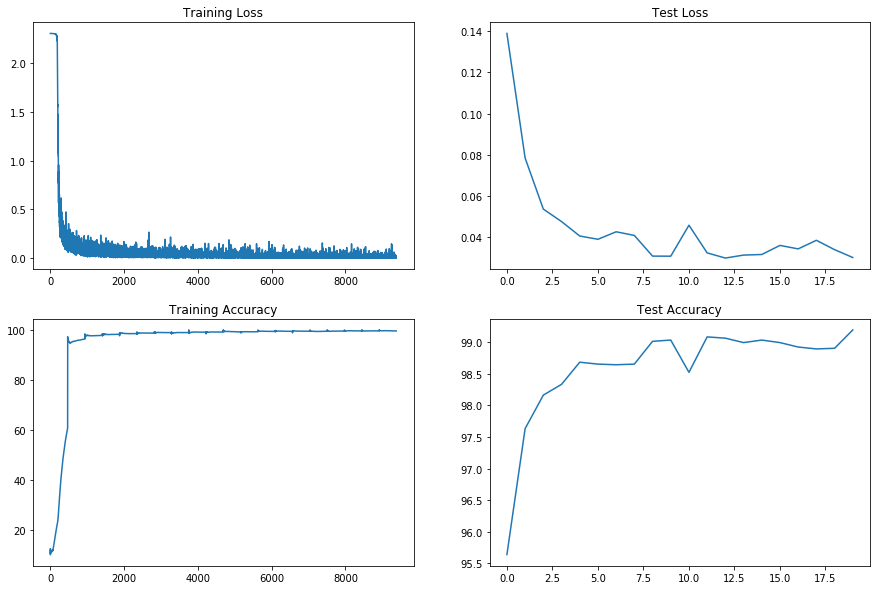

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")